# Pipeline for analyzing flow cytometry data

In [1]:
from FlowCytometryTools import *
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import glob
import seaborn as sns

import os
import sys

path = '/Users/andrewng/Documents/AHN_FlowTools/'
if not path in sys.path:
    sys.path.insert(1, path)
del path

from AHN_FlowTools import *

sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

In [2]:
datadir = list()

datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20180706_FBtuning/Plate1/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20180706_FBtuning/Plate2/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20180706_FBtuning/Plate3/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20180706_FBtuning/Plate4/')

date = '20180706'

allfiles = {}
strains = ['Plate1','Plate2','Plate3','Plate4']

for i in range(len(datadir)):
    files = glob.glob(datadir[i] + '*.fcs')
    allfiles[strains[i]] = files

In [3]:
rows = ['A','B','C','D','E','F','G','H']
cols = ['01','02','03','04','05','06','07','08','09','10','11','12']

In [4]:
plateraw = pd.DataFrame(index = rows, columns = cols)

panelDict = {strain:plateraw for strain in strains}
allplates = pd.Panel(panelDict)

/Users/andrewng/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
for strain in strains:
    for f in allfiles[strain]:
        c = f[-10:-8]
        r = f[-11]
        call = r + c
        allplates[strain].set_value(r, c, FCMeasurement(ID = call, datafile = f))

/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [6]:
def FCdatastats(platesort,normalized=None,rows=None,cols=None,FITCthresh=None,FSCthresh=None):

    #Calculate the linear median, mean, and SD for each of the wells. Create two different Panels, one for FITC and one
    #for mCherry. In each Panel store a DataFrame containing the median, mean, SD, and CV

    if normalized is None:
        normalized = True
    if rows is None:
        rows = ['A','B','C','D','E','F','G','H']
    if cols is None:
        cols = ['01','02','03','04','05','06','07','08','09','10','11','12']
    if FITCthresh is None:
        FITCthresh = 100
    if FSCthresh is None:
        FSCthresh = 1000

    empty = pd.DataFrame(index = rows, columns = cols)

    FITCstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty, 'cv':empty})
    RFPstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty})
    BFPstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty})

    for row in rows:
        for col in cols:

            try:
                FCM = gate(platesort.loc[row,col],'FITC-H',FITCthresh)

                FCM2 = FCM[FCM['SSC-H'] > FSCthresh]
            except TypeError:
                continue

            try:
                if normalized == True:
                    FITC = FCM2['FITC-H']/FCM2['SSC-H']
                    RFP = FCM2['PE-Texas Red-H']/FCM2['SSC-H']
                    BFP = FCM2['DAPI-H']/FCM2['SSC-H']

                elif normalized == False:
                    FITC = FCM2['FITC-H']
                    RFP = FCM2['PE-Texas Red-H']
                    BFP = FCM2['DAPI-H']

                FITCstats.raw.set_value(row, col, FITC)
                FITCstats.med.set_value(row,col,FITC.median(axis=0))
                FITCstats.avg.set_value(row,col,FITC.mean(axis=0))
                FITCstats.sd.set_value(row,col,FITC.std(axis=0))
                FITCstats.cv.set_value(row,col,FITCstats.avg.loc[row,col]/FITCstats.sd.loc[row,col])

                RFPstats.raw.set_value(row, col, RFP)
                RFPstats.med.set_value(row,col,RFP.median(axis=0))
                RFPstats.avg.set_value(row,col,RFP.mean(axis=0))
                RFPstats.sd.set_value(row,col,RFP.std(axis=0))
                RFPstats.cv.set_value(row,col,RFPstats.avg.loc[row,col]/RFPstats.sd.loc[row,col])

                BFPstats.raw.set_value(row, col, BFP)
                BFPstats.med.set_value(row,col,BFP.median(axis=0))
                BFPstats.avg.set_value(row,col,BFP.mean(axis=0))
                BFPstats.sd.set_value(row,col,BFP.std(axis=0))
                BFPstats.cv.set_value(row,col,BFPstats.avg.loc[row,col]/BFPstats.sd.loc[row,col])
                
            except (AttributeError, TypeError):
                continue

    return [FITCstats, RFPstats, BFPstats]


In [7]:
FITCnorm = {}
RFPnorm = {}
BFPnorm = {}

for strain in strains: 
    [FITCnorm[strain], RFPnorm[strain],BFPnorm[strain]] = FCdatastats(allplates[strain],1,rows,cols,10,1000)


/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:45: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: FutureWarning: set_value is deprecated and will be remov

In [8]:
#Define the rows

Econcind = range(8)
Pconcind = range(12)

Econc = list()
Pconc = list()

for j in range(7):
    Econc.append(round(30*0.5**j,2))

for i in range(11):
    Pconc.append(round(100*0.5**i,2))

Px = [round(100*0.5**i,2) for i in range(11)]

Econc.append(0)
Pconc.append(0)
Px.append(0)

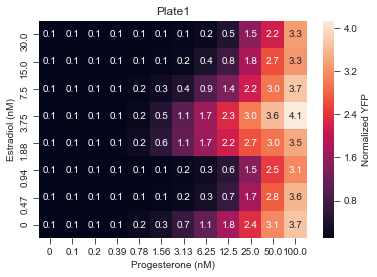

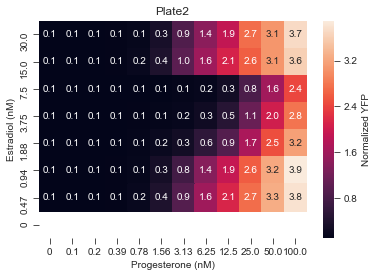

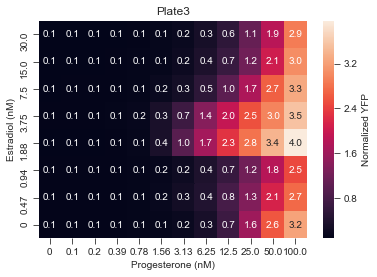

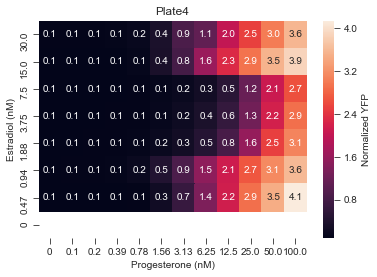

In [9]:
for plate in strains:
    sns.heatmap(FITCnorm[plate].med.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,annot=True,fmt='.1f',cbar_kws={'label': 'Normalized YFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'YFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

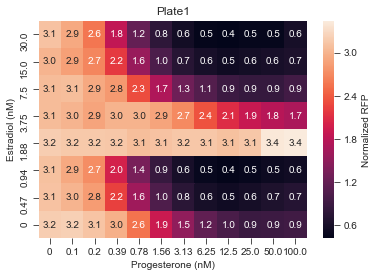

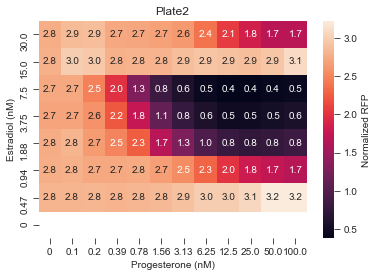

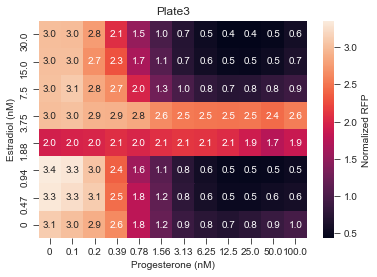

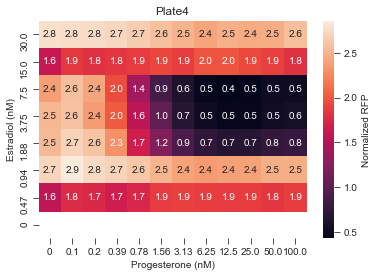

In [10]:
for plate in strains:
    sns.heatmap(RFPnorm[plate].med.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,annot=True,fmt='.1f',cbar_kws={'label': 'Normalized RFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'RFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

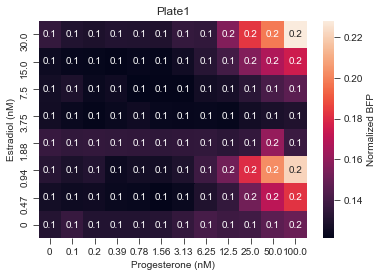

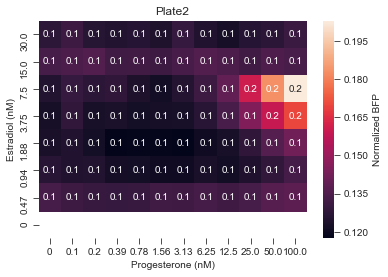

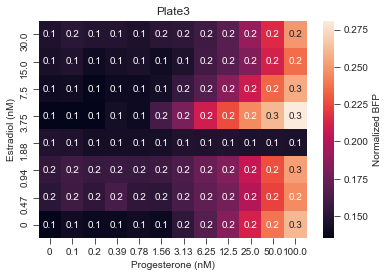

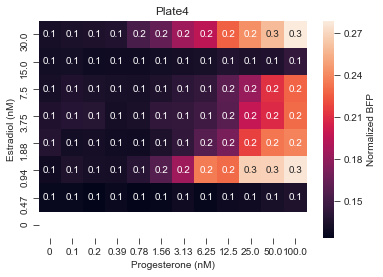

In [11]:
for plate in strains:
    sns.heatmap(BFPnorm[plate].med.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,annot=True,fmt='.1f',cbar_kws={'label': 'Normalized BFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'BFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

## Work up histograms of the data in a 96 well plate format

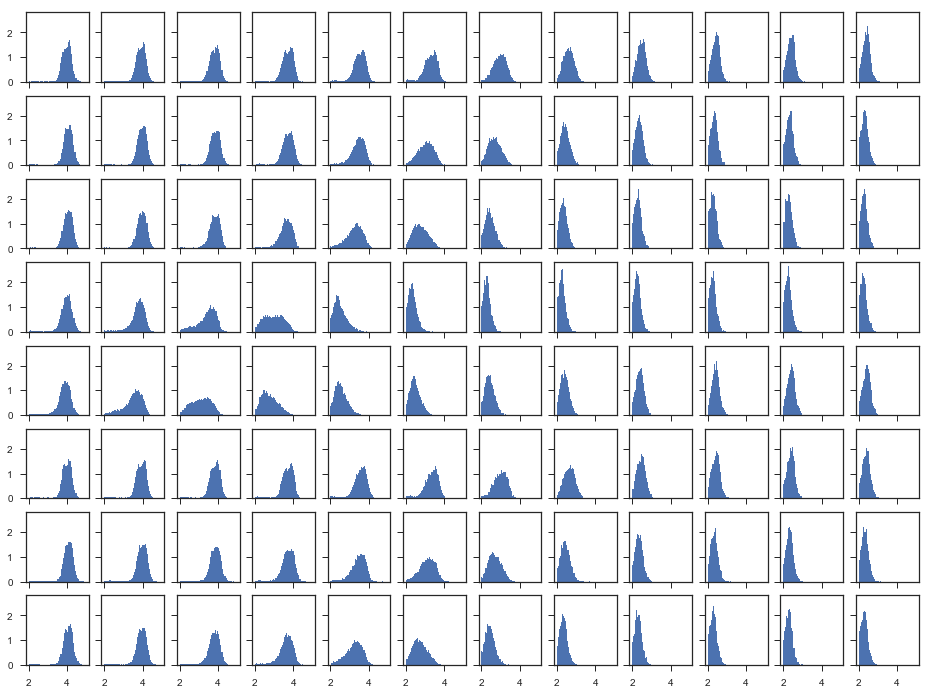

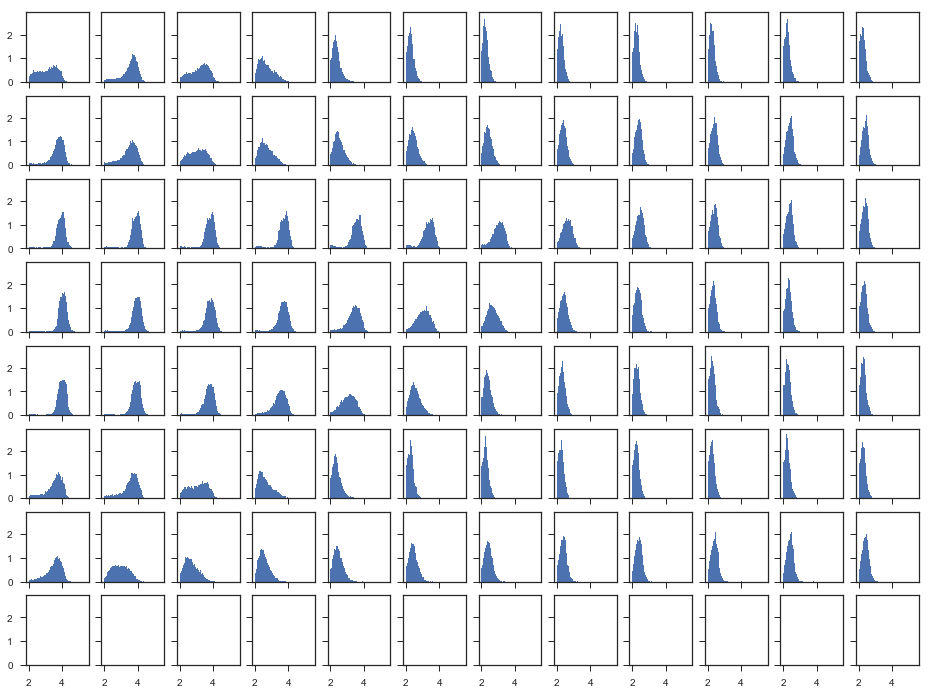

In [12]:
for plate in strains:
    FITCclean = pd.DataFrame(index = rows, columns = cols)
    logFITCclean = pd.DataFrame(index = rows, columns = cols)

    for row in rows:
        for col in cols:
            try:
                FITCclean.loc[row,col] = cleandata(allplates[plate].loc[row,col].data['FITC-A'].values,100)
                logFITCclean.loc[row,col] = np.log10(cleandata(allplates[plate].loc[row,col].data['FITC-A'].values,100))
            except:
                continue

    FITC_bincenter = pd.DataFrame(index = rows, columns = cols)
    FITC_histy = pd.DataFrame(index = rows, columns = cols)

    fig, ax = plt.subplots(8, 12,sharex = True, sharey = True, figsize=(16,12))

    for i in range(8):
        for j in range(12):
            try:
                FITC_histy.iloc[i,j],FITC_bincenter.iloc[i,j] = ax[i,j].hist(logFITCclean.iloc[i,j][~np.isnan(logFITCclean.iloc[i,j])],50,normed=1)
            except:
                continue

    dest = date + plate + 'fullhist'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

In [18]:
plt.set_cmap('plasma')

# Process data into arrays; calculate average and standard deviation

In [9]:
promoters = ['pZ3-5x','pZ3-4x','pZ3-3x','pZ3-2x','pZ3-1x']
keys = ['Key m4','Key m9','Key m12','Key m15','pRNR2-m9']

In [10]:
#Average across the triplicate plates

pFITCavg = pd.DataFrame(index = promoters, columns = cols)
pRFPavg = pd.DataFrame(index = promoters, columns = cols)
pBFPavg = pd.DataFrame(index = promoters, columns = cols)

pFITCstd = pd.DataFrame(index = promoters, columns = cols)
pRFPstd = pd.DataFrame(index = promoters, columns = cols)
pBFPstd = pd.DataFrame(index = promoters, columns = cols)

kFITCavg = pd.DataFrame(index = keys, columns = cols)
kRFPavg = pd.DataFrame(index = keys, columns = cols)
kBFPavg = pd.DataFrame(index = keys, columns = cols)

kFITCstd = pd.DataFrame(index = keys, columns = cols)
kRFPstd = pd.DataFrame(index = keys, columns = cols)
kBFPstd = pd.DataFrame(index = keys, columns = cols)


for j, r in enumerate(promoters[0:3]):
    for i, c in enumerate(cols):
        pFITCavg.set_value(r, c, np.mean([FITCnorm['Plate1'].med.iloc[j,i],FITCnorm['Plate1'].med.iloc[j+5,i],FITCnorm['Plate2'].med.iloc[j+2,i]]))
        pFITCstd.set_value(r, c, np.std([FITCnorm['Plate1'].med.iloc[j,i],FITCnorm['Plate1'].med.iloc[j+5,i],FITCnorm['Plate2'].med.iloc[j+2,i]]))

        pRFPavg.set_value(r, c, np.mean([RFPnorm['Plate1'].med.iloc[j,i],RFPnorm['Plate1'].med.iloc[j+5,i],RFPnorm['Plate2'].med.iloc[j+2,i]]))
        pRFPstd.set_value(r, c, np.std([RFPnorm['Plate1'].med.iloc[j,i],RFPnorm['Plate1'].med.iloc[j+5,i],RFPnorm['Plate2'].med.iloc[j+2,i]]))

        pBFPavg.set_value(r, c, np.mean([BFPnorm['Plate1'].med.iloc[j,i],BFPnorm['Plate1'].med.iloc[j+5,i],BFPnorm['Plate2'].med.iloc[j+2,i]]))
        pBFPstd.set_value(r, c, np.std([BFPnorm['Plate1'].med.iloc[j,i],BFPnorm['Plate1'].med.iloc[j+5,i],BFPnorm['Plate2'].med.iloc[j+2,i]]))

for j, r in enumerate(promoters[3:5]):
    for i, c in enumerate(cols):
        pFITCavg.set_value(r, c, np.mean([FITCnorm['Plate1'].med.iloc[j+3,i],FITCnorm['Plate2'].med.iloc[j,i],FITCnorm['Plate2'].med.iloc[j+5,i]]))
        pFITCstd.set_value(r, c, np.std([FITCnorm['Plate1'].med.iloc[j+3,i],FITCnorm['Plate2'].med.iloc[j,i],FITCnorm['Plate2'].med.iloc[j+5,i]]))

        pRFPavg.set_value(r, c, np.mean([RFPnorm['Plate1'].med.iloc[j+3,i],RFPnorm['Plate2'].med.iloc[j,i],RFPnorm['Plate2'].med.iloc[j+5,i]]))
        pRFPstd.set_value(r, c, np.std([RFPnorm['Plate1'].med.iloc[j+3,i],RFPnorm['Plate2'].med.iloc[j,i],RFPnorm['Plate2'].med.iloc[j+5,i]]))

        pBFPavg.set_value(r, c, np.mean([BFPnorm['Plate1'].med.iloc[j+3,i],BFPnorm['Plate2'].med.iloc[j,i],BFPnorm['Plate2'].med.iloc[j+5,i]]))
        pBFPstd.set_value(r, c, np.std([BFPnorm['Plate1'].med.iloc[j+3,i],BFPnorm['Plate2'].med.iloc[j,i],BFPnorm['Plate2'].med.iloc[j+5,i]]))

for j, r in enumerate(keys[0:3]):
    for i, c in enumerate(cols):
        kFITCavg.set_value(r, c, np.mean([FITCnorm['Plate3'].med.iloc[j,i],FITCnorm['Plate3'].med.iloc[j+5,i],FITCnorm['Plate4'].med.iloc[j+2,i]]))
        kFITCstd.set_value(r, c, np.std([FITCnorm['Plate3'].med.iloc[j,i],FITCnorm['Plate3'].med.iloc[j+5,i],FITCnorm['Plate4'].med.iloc[j+2,i]]))

        kRFPavg.set_value(r, c, np.mean([RFPnorm['Plate3'].med.iloc[j,i],RFPnorm['Plate3'].med.iloc[j+5,i],RFPnorm['Plate4'].med.iloc[j+2,i]]))
        kRFPstd.set_value(r, c, np.std([RFPnorm['Plate3'].med.iloc[j,i],RFPnorm['Plate3'].med.iloc[j+5,i],RFPnorm['Plate4'].med.iloc[j+2,i]]))

        kBFPavg.set_value(r, c, np.mean([BFPnorm['Plate3'].med.iloc[j,i],BFPnorm['Plate3'].med.iloc[j+5,i],BFPnorm['Plate4'].med.iloc[j+2,i]]))
        kBFPstd.set_value(r, c, np.std([BFPnorm['Plate3'].med.iloc[j,i],BFPnorm['Plate3'].med.iloc[j+5,i],BFPnorm['Plate4'].med.iloc[j+2,i]]))

for j, r in enumerate(keys[3:5]):
    for i, c in enumerate(cols):
        kFITCavg.set_value(r, c, np.mean([FITCnorm['Plate3'].med.iloc[j+3,i],FITCnorm['Plate4'].med.iloc[j,i],FITCnorm['Plate4'].med.iloc[j+5,i]]))
        kFITCstd.set_value(r, c, np.std([FITCnorm['Plate3'].med.iloc[j+3,i],FITCnorm['Plate4'].med.iloc[j,i],FITCnorm['Plate4'].med.iloc[j+5,i]]))

        kRFPavg.set_value(r, c, np.mean([RFPnorm['Plate3'].med.iloc[j+3,i],RFPnorm['Plate4'].med.iloc[j,i],RFPnorm['Plate4'].med.iloc[j+5,i]]))
        kRFPstd.set_value(r, c, np.std([RFPnorm['Plate3'].med.iloc[j+3,i],RFPnorm['Plate4'].med.iloc[j,i],RFPnorm['Plate4'].med.iloc[j+5,i]]))

        kBFPavg.set_value(r, c, np.mean([BFPnorm['Plate3'].med.iloc[j+3,i],BFPnorm['Plate4'].med.iloc[j,i],BFPnorm['Plate4'].med.iloc[j+5,i]]))
        kBFPstd.set_value(r, c, np.std([BFPnorm['Plate3'].med.iloc[j+3,i],BFPnorm['Plate4'].med.iloc[j,i],BFPnorm['Plate4'].med.iloc[j+5,i]]))


/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or 

In [11]:
#Read in data from SyntheticCircuitConstitutivePromoters
cFITCavg = pd.read_pickle('FITCavg_constprom.pkl')
cRFPavg = pd.read_pickle('RFPavg_constprom.pkl')
cBFPavg = pd.read_pickle('BFPavg_constprom.pkl')

cFITCstd = pd.read_pickle('FITCstd_constprom.pkl')
cRFPstd = pd.read_pickle('RFPstd_constprom.pkl')
cBFPstd = pd.read_pickle('BFPstd_constprom.pkl')

In [28]:
def get_YFP_color():
    color = iter(sns.color_palette(sns.color_palette("YlOrBr", 8)))
    return(color)

YFP_color = get_YFP_color()
YFP_color_OL = get_YFP_color()
c_YFP = next(YFP_color)
c_YFP_OL = next(YFP_color_OL)

# Plot Data

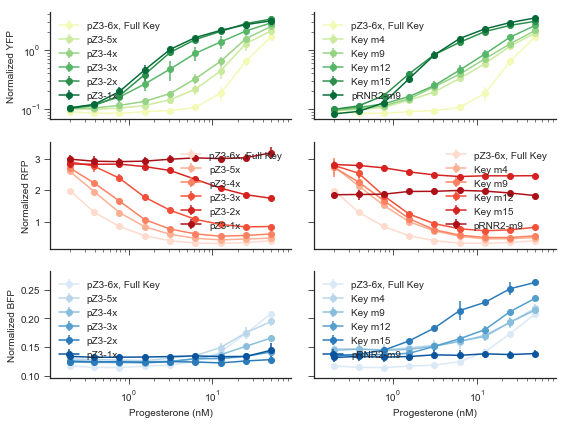

In [32]:
#Plot everything side-by-side

fig, ax = plt.subplots(3, 2,sharex=True,sharey='row',figsize=(8,6))

Yellows = sns.color_palette('YlGn',6)
Reds = sns.color_palette('Reds',6)
Blues = sns.color_palette('Blues',6)

for i in range(2):
    ax[0,i].errorbar(Pconc[1:10],cFITCavg.iloc[4,1:10],yerr = cFITCstd.iloc[4,1:10],fmt = 'o-',color = Yellows[0], label='pZ3-6x, Full Key')
    ax[1,i].errorbar(Pconc[1:10],cRFPavg.iloc[4,1:10],yerr = cRFPstd.iloc[4,1:10],fmt = 'o-',color = Reds[0],label='pZ3-6x, Full Key')
    ax[2,i].errorbar(Pconc[1:10],cBFPavg.iloc[4,1:10],yerr = cBFPstd.iloc[4,1:10],fmt = 'o-',color = Blues[0],label='pZ3-6x, Full Key')

for x, i in enumerate(promoters):
    #Plot YFP values
    ax[0,0].errorbar(Pconc[1:10],pFITCavg.iloc[x,1:10],yerr = pFITCstd.iloc[x,1:10],fmt = 'o-',color = Yellows[x+1], label=i)
    
    #Plot RFP values
    ax[1,0].errorbar(Pconc[1:10],pRFPavg.iloc[x,1:10],yerr = pRFPstd.iloc[x,1:10],fmt = 'o-',color = Reds[x+1],label=i)
    
    #Plot BFP values
    ax[2,0].errorbar(Pconc[1:10],pBFPavg.iloc[x,1:10],yerr = pBFPstd.iloc[x,1:10],fmt = 'o-',color = Blues[x+1],label=i)

for x, i in enumerate(keys):
    #Plot YFP values
    ax[0,1].errorbar(Pconc[1:10],kFITCavg.iloc[x,1:10],yerr = kFITCstd.iloc[x,1:10],fmt = 'o-',color = Yellows[x+1], label=i)

    #Plot RFP values
    ax[1,1].errorbar(Pconc[1:10],kRFPavg.iloc[x,1:10],yerr = kRFPstd.iloc[x,1:10],fmt = 'o-',color = Reds[x+1],label=i)
    
    #Plot BFP values
    ax[2,1].errorbar(Pconc[1:10],kBFPavg.iloc[x,1:10],yerr = kBFPstd.iloc[x,1:10],fmt = 'o-',color = Blues[x+1],label=i)

for i in range(2):
    for j in range(3):
        ax[j,i].legend()
    
#ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Normalized YFP')
ax[0,0].set_yscale('log')

ax[1,0].set_ylabel('Normalized RFP')
#ax[1,0].set_yscale('log')

ax[2,0].set_ylabel('Normalized BFP')
#ax[2,0].set_yscale('log')

ax[2,0].set_xlabel('Progesterone (nM)')
ax[2,0].set_xscale('log')

ax[2,1].set_xlabel('Progesterone (nM)')
ax[2,1].set_xscale('log')
#ax[2].set_xticklabels(Pconc[::-1],rotation = 60)

# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
plt.tight_layout()
    
sns.despine()

dest = date + 'YRBcomparison'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()

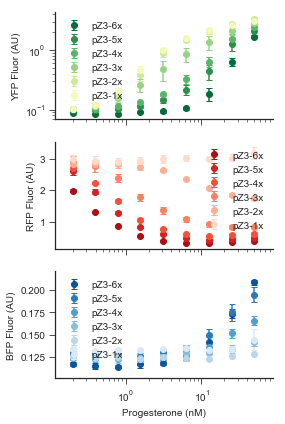

In [32]:
#Examine all the pZ3 promoters

fig, ax = plt.subplots(3, 1,sharex=True,sharey='row',figsize=(4,6))

Yellows = sns.color_palette('YlGn',6)
Reds = sns.color_palette('Reds',6)
Blues = sns.color_palette('Blues',6)

ax[0].errorbar(Pconc[1:10],cFITCavg.iloc[4,1:10],yerr = cFITCstd.iloc[4,1:10],capsize=3,fmt = 'o',color = Yellows[5], label='pZ3-6x')
ax[1].errorbar(Pconc[1:10],cRFPavg.iloc[4,1:10],yerr = cRFPstd.iloc[4,1:10],capsize=3,fmt = 'o',color = Reds[5],label='pZ3-6x')
ax[2].errorbar(Pconc[1:10],cBFPavg.iloc[4,1:10],yerr = cBFPstd.iloc[4,1:10],capsize=3,fmt = 'o',color = Blues[5],label='pZ3-6x')

for x, i in enumerate(promoters):
    #Plot YFP values
    ax[0].errorbar(Pconc[1:10],pFITCavg.iloc[x,1:10],yerr = pFITCstd.iloc[x,1:10],capsize=3,fmt = 'o',color = Yellows[4-x], label=i)
    
    #Plot RFP values
    ax[1].errorbar(Pconc[1:10],pRFPavg.iloc[x,1:10],yerr = pRFPstd.iloc[x,1:10],capsize=3,fmt = 'o',color = Reds[4-x],label=i)
    
    #Plot BFP values
    ax[2].errorbar(Pconc[1:10],pBFPavg.iloc[x,1:10],yerr = pBFPstd.iloc[x,1:10],capsize=3,fmt = 'o',color = Blues[4-x],label=i)


for j in range(3):
        ax[j].legend()
    
#ax[0,0].set_yscale('log')
ax[0].set_ylabel('YFP Fluor (AU)')
ax[0].set_yscale('log')

ax[1].set_ylabel('RFP Fluor (AU)')
#ax[1,0].set_yscale('log')

ax[2].set_ylabel('BFP Fluor (AU)')
#ax[2,0].set_yscale('log')

ax[2].set_xlabel('Progesterone (nM)')
ax[2].set_xscale('log')
#ax[2].set_xticklabels(Pconc[::-1],rotation = 60)

# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
plt.tight_layout()
    
sns.despine()

dest = date + 'promotersYRBcomparison'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()

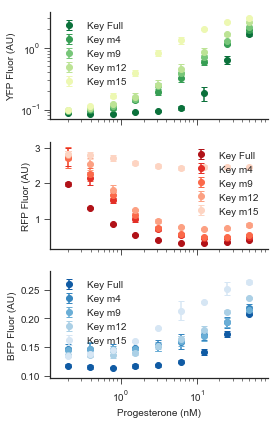

In [35]:
#Examine all the key lengths

fig, ax = plt.subplots(3, 1,sharex=True,sharey='row',figsize=(4,6))

Yellows = sns.color_palette('YlGn',5)
Reds = sns.color_palette('Reds',5)
Blues = sns.color_palette('Blues',5)

ax[0].errorbar(Pconc[1:10],cFITCavg.iloc[4,1:10],yerr = cFITCstd.iloc[4,1:10],fmt = 'o',capsize=3,color = Yellows[4], label='Key Full')
ax[1].errorbar(Pconc[1:10],cRFPavg.iloc[4,1:10],yerr = cRFPstd.iloc[4,1:10],fmt = 'o',capsize=3,color = Reds[4],label='Key Full')
ax[2].errorbar(Pconc[1:10],cBFPavg.iloc[4,1:10],yerr = cBFPstd.iloc[4,1:10],fmt = 'o',capsize=3,color = Blues[4],label='Key Full')

for x, i in enumerate(keys[0:4]):
    #Plot YFP values
    ax[0].errorbar(Pconc[1:10],kFITCavg.iloc[x,1:10],yerr = kFITCstd.iloc[x,1:10],capsize=3,fmt = 'o',color = Yellows[3-x], label=i)

    #Plot RFP values
    ax[1].errorbar(Pconc[1:10],kRFPavg.iloc[x,1:10],yerr = kRFPstd.iloc[x,1:10],capsize=3,fmt = 'o',color = Reds[3-x],label=i)
    
    #Plot BFP values
    ax[2].errorbar(Pconc[1:10],kBFPavg.iloc[x,1:10],yerr = kBFPstd.iloc[x,1:10],capsize=3,fmt = 'o',color = Blues[3-x],label=i)

for j in range(3):
        ax[j].legend()
    
#ax[0,0].set_yscale('log')
ax[0].set_ylabel('YFP Fluor (AU)')
ax[0].set_yscale('log')

ax[1].set_ylabel('RFP Fluor (AU)')
#ax[1,0].set_yscale('log')

ax[2].set_ylabel('BFP Fluor (AU)')
#ax[2,0].set_yscale('log')

ax[2].set_xlabel('Progesterone (nM)')
ax[2].set_xscale('log')
#ax[2].set_xticklabels(Pconc[::-1],rotation = 60)

# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
plt.tight_layout()
    
sns.despine()

dest = date + 'keysYRBcomparison'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()




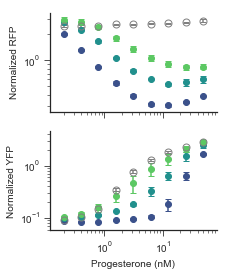

In [15]:
## Plot the most well-separated promoters

Yellows = sns.color_palette('viridis_r',3)
Reds = sns.color_palette('viridis_r',3)

fig, ax = plt.subplots(2, 1,sharex=True,sharey='row',figsize=(3,4))

ax[0].errorbar(Pconc[1:10],cRFPavg.iloc[4,1:10],yerr=cRFPstd.iloc[4,1:10],capsize=3,fmt ='o', color = Reds[2], label = 'pZ3_6x')
ax[0].errorbar(Pconc[1:10],pRFPavg.iloc[1,1:10],yerr=pRFPstd.iloc[1,1:10],capsize=3,fmt ='o', color = Reds[1], label = 'pZ3_4x')
ax[0].errorbar(Pconc[1:10],pRFPavg.iloc[2,1:10],yerr=pRFPstd.iloc[2,1:10],capsize=3,fmt ='o', color = Reds[0], label = 'pZ3_3x')
ax[0].errorbar(Pconc[1:10],cRFPavg.iloc[0,1:10],yerr=cRFPstd.iloc[0,1:10],capsize=3,fmt ='o', ms=7,mew=1,mec='grey',mfc = 'none', color = 'grey', label = 'OL')

ax[1].errorbar(Pconc[1:10],cFITCavg.iloc[4,1:10],yerr=cFITCstd.iloc[4,1:10],capsize=3,fmt ='o', color = Yellows[2], label = 'pZ3_6x')
ax[1].errorbar(Pconc[1:10],pFITCavg.iloc[1,1:10],yerr=pFITCstd.iloc[1,1:10],capsize=3,fmt ='o', color = Yellows[1], label = 'pZ3_4x')
ax[1].errorbar(Pconc[1:10],pFITCavg.iloc[2,1:10],yerr=pFITCstd.iloc[2,1:10],capsize=3,fmt ='o', color = Yellows[0], label = 'pZ3_3x')
ax[1].errorbar(Pconc[1:10],cFITCavg.iloc[0,1:10],yerr=cFITCstd.iloc[0,1:10],capsize=3,fmt ='o', ms=7,mew=1,mec='grey',mfc = 'none', color = 'grey', label = 'OL')

ax[0].set_ylabel('Normalized RFP')
ax[0].set_yscale('log')

ax[1].set_ylabel('Normalized YFP')
ax[1].set_yscale('log')

ax[1].set_xlabel('Progesterone (nM)')
ax[1].set_xscale('log')

#for i in range(2):
#    ax[i].legend()
#ax[1].set_xticks(Econcind)
#ax[1].set_xticklabels(Econc[::-1],rotation = 60)
#ax[0,i].set_title('Pg = ' + Pconc[i+2])

# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
#plt.tight_layout()
    
sns.despine()

dest = date + 'YRpromoters'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()

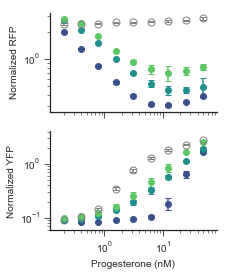

In [16]:
## Plot the most well-separated keys

Yellows = sns.color_palette('viridis_r',3)
Reds = sns.color_palette('viridis_r',3)

fig, ax = plt.subplots(2, 1,sharex=True,sharey='row',figsize=(3,4))

ax[0].errorbar(Pconc[1:10],cRFPavg.iloc[4,1:10],yerr=cRFPstd.iloc[4,1:10],capsize =3,fmt ='o', color = Reds[2], label = 'pZ3_6x')
ax[0].errorbar(Pconc[1:10],kRFPavg.iloc[0,1:10],yerr=kFITCstd.iloc[0,1:10],capsize =3,fmt ='o', color = Reds[1])
ax[0].errorbar(Pconc[1:10],kRFPavg.iloc[2,1:10],yerr=kFITCstd.iloc[2,1:10],capsize =3,fmt ='o', color = Reds[0])
ax[0].errorbar(Pconc[1:10],cRFPavg.iloc[0,1:10],yerr=cRFPstd.iloc[0,1:10],capsize =3,fmt ='o', ms=7,mew=1,mec='grey',mfc = 'none', color = 'grey', label = 'OL')

ax[1].errorbar(Pconc[1:10],cFITCavg.iloc[4,1:10],yerr=cFITCstd.iloc[4,1:10],capsize =3,fmt ='o', color = Yellows[2], label = 'pZ3_6x')
ax[1].errorbar(Pconc[1:10],kFITCavg.iloc[0,1:10],yerr=kFITCstd.iloc[0,1:10],capsize =3,fmt ='o', color = Yellows[1], label = 'm9')
ax[1].errorbar(Pconc[1:10],kFITCavg.iloc[2,1:10],yerr=kFITCstd.iloc[2,1:10],capsize =3,fmt ='o', color = Yellows[0], label = 'm12')
ax[1].errorbar(Pconc[1:10],cFITCavg.iloc[0,1:10],yerr=cFITCstd.iloc[0,1:10],capsize =3,fmt ='o', ms=7,mew=1,mec='grey',mfc = 'none', color = 'grey', label = 'OL')

ax[0].set_ylabel('Normalized RFP')
ax[0].set_yscale('log')

ax[1].set_ylabel('Normalized YFP')
ax[1].set_yscale('log')

ax[1].set_xlabel('Progesterone (nM)')
ax[1].set_xscale('log')
#ax[1].set_xticks(Econcind)
#ax[1].set_xticklabels(Econc[::-1],rotation = 60)
#ax[0,i].set_title('Pg = ' + Pconc[i+2])

# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
#plt.tight_layout()
    
sns.despine()

dest = date + 'YRkeys'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()